In [1]:
from itertools import chain
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.ma import masked_where

In [2]:
train_data = pd.read_csv('data/split/train_data.csv')
test_data = pd.read_csv('data/split/test_data.csv')

In [3]:
timestamps = train_data['timestamp']

In [4]:
delay = 30      # s
threshold = 30  # s

t = int(timestamps[0])
c = 0
indexes = []
# print(len(timestamps[1:]))
for i, timestamp in enumerate(timestamps[1:]):
    diff = int(timestamp) - t
    t = int(timestamp)

    # missing data from sensors
    # at least one timestamp is missing
    if diff >= 60:
        indexes.append(i)
        c += diff // 30

print(f"Total missing values: {c}")

Total missing values: 483


In [5]:
indexes[0]

31

As we can see here, there is one missing row on between index 31 and 21

In [6]:
train_data.iloc[indexes[0]:indexes[0]+2]

,timestamp,light_air,light_ground,moisture_ground,dht_air_humidity,dht_air_temperature,dht_ground_humidity,dht_ground_temperature
31,1697064406,2277,1767,1014,40,24.5,40,24.2
32,1697064543,704,834,1047,42,24.2,44,24.4


Insert missing values as null

In [7]:
train_data.shape

(9000, 8)

Add missing values for later inference

In [8]:
import numpy as np

# Assuming indexes and timestamps are defined somewhere in your code
cols = train_data.columns
new_data = []
x = 0

for index in indexes:
    diff = timestamps[index+1] - timestamps[index]
    n_values = diff // 30
    
    if n_values > 0:
        # nan_values = np.full((n_values, len(cols)), np.nan)
        for i in range(n_values):
            value = [np.nan] * len(cols)
            value[0] = timestamps[index] + (i + 1) * 30
            new_data.append(value)

np.array(new_data).shape

(483, 8)

In [9]:
new_data_df = pd.DataFrame(new_data, columns=cols)
combined_df = pd.concat([train_data, new_data_df], ignore_index=True)

combined_df.sort_values('timestamp', inplace=True)
combined_df.reset_index(drop=True, inplace=True)

combined_df

,timestamp,light_air,light_ground,moisture_ground,dht_air_humidity,dht_air_temperature,dht_ground_humidity,dht_ground_temperature
0,1697063380,2311.0,1999.0,944.0,40.0,24.4,40.0,24.3
1,1697063416,2325.0,2006.0,929.0,40.0,24.3,40.0,24.3
2,1697063450,2320.0,2003.0,952.0,40.0,24.3,40.0,24.3
3,1697063484,2329.0,1999.0,950.0,40.0,24.3,40.0,24.2
4,1697063518,2307.0,1983.0,961.0,40.0,24.3,40.0,24.2
...,...,...,...,...,...,...,...,...
9478,1697375712,678.0,2465.0,1249.0,57.0,21.9,58.0,21.8
9479,1697375745,655.0,2419.0,1232.0,57.0,21.9,58.0,21.8
9480,1697375779,629.0,2410.0,206.0,57.0,21.9,58.0,21.8
9481,1697375815,661.0,2352.0,1351.0,57.0,21.9,58.0,21.8


plot data appended

In [10]:
masked_data = np.ma.masked_invalid(combined_df.values)

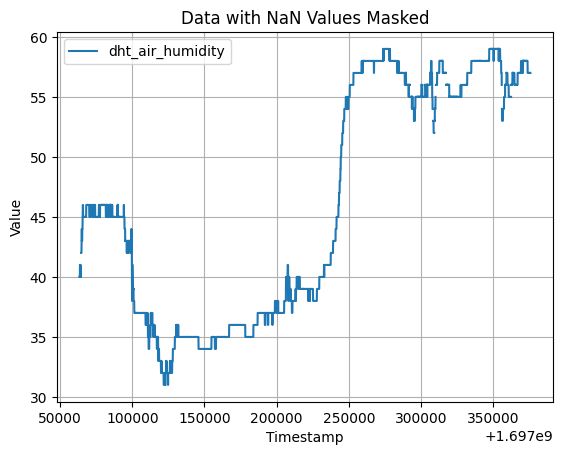

In [11]:
# for col_idx, col_name in enumerate(combined_df.columns[1:]):  # excluding 'timestamp'
#     plt.plot(combined_df['timestamp'], masked_data[:, col_idx + 1], label=col_name)
# only one column is selected for simplicity
col_name = 'dht_air_humidity'

plt.plot(combined_df['timestamp'], masked_data[:, 3 + 1], label=col_name)
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Data with NaN Values Masked')
plt.legend()
plt.grid(True)
plt.show()

inference data appended from all columns

In [12]:
for col in combined_df.columns:
    combined_df[col] = combined_df[col].interpolate()

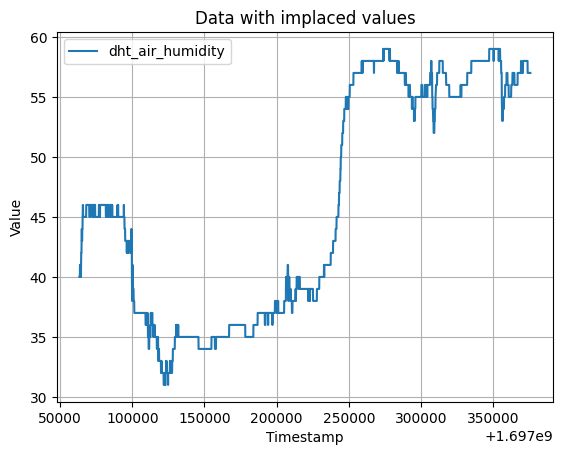

In [13]:
plt.plot(combined_df['timestamp'], combined_df[col_name], label=col_name)
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Data with implaced values')
plt.legend()
plt.grid(True)
plt.show()

extract data to CSV that is used by model

In [15]:
combined_df.to_csv("./data/processed/train.csv")